# Estimating COVID-19's $R_t$ in Real-Time for Canada

> - This analysis is adapted from [Kevin Systrom's analysis for the US](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb). See also [this page](https://rt.live/) for a beautiful visualization of the US results. 
> - I've applied his model to Canadian data ([details here](canada-Rt-calcs.html)) and the results are shown in the graphs below.
> - The introductory text below is from Kevin Systrom's analysis.

## Introduction

In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) changes $R_t$. Knowing the current $R_t$ is essential. When $R_t\gg1$, the pandemic will spread through a large part of the population. If $R_t<1$, the pandemic will slow quickly before it has a chance to infect many people. The lower the $R_t$: the more manageable the situation. In general, any $R_t<1$ means things are under control.

The value of $R_t$ helps us in two ways. (1) It helps us understand how effective our measures have been controlling an outbreak and (2) it gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety. [Well-respected epidemiologists argue](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) that tracking $R_t$ is the only way to manage through this crisis.

## Results for Canada

The figures below show estimated $R_t$ for each Canadian province that has a sufficiently large outbreak for the model to be applicable. The first figure shows the evolution of $R_t$ over time and the second figure shows a snapshot of the current estimated values.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [2]:
# Get Rt values calculated in canada-Rt-calcs.ipynb notebook
final_results = pd.read_csv('data/canada-rt.csv', parse_dates=['date'],
                            index_col=['state', 'date'])

In [3]:
def plot_rt(result, ax, state_name, date_min=None):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    if date_min is None:
        date_min = index[0] - pd.Timedelta(days=1)
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=index[0]-pd.Timedelta(days=1),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='b', lw=2, label='$R_t=1.0$', alpha=.5);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.tick_params(right=False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(date_min, result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    for label in ax.get_xticklabels():
        label.set_fontweight('normal')
    ax.get_yticklabels()[2].set_color('b') 
    fig.set_facecolor('w')

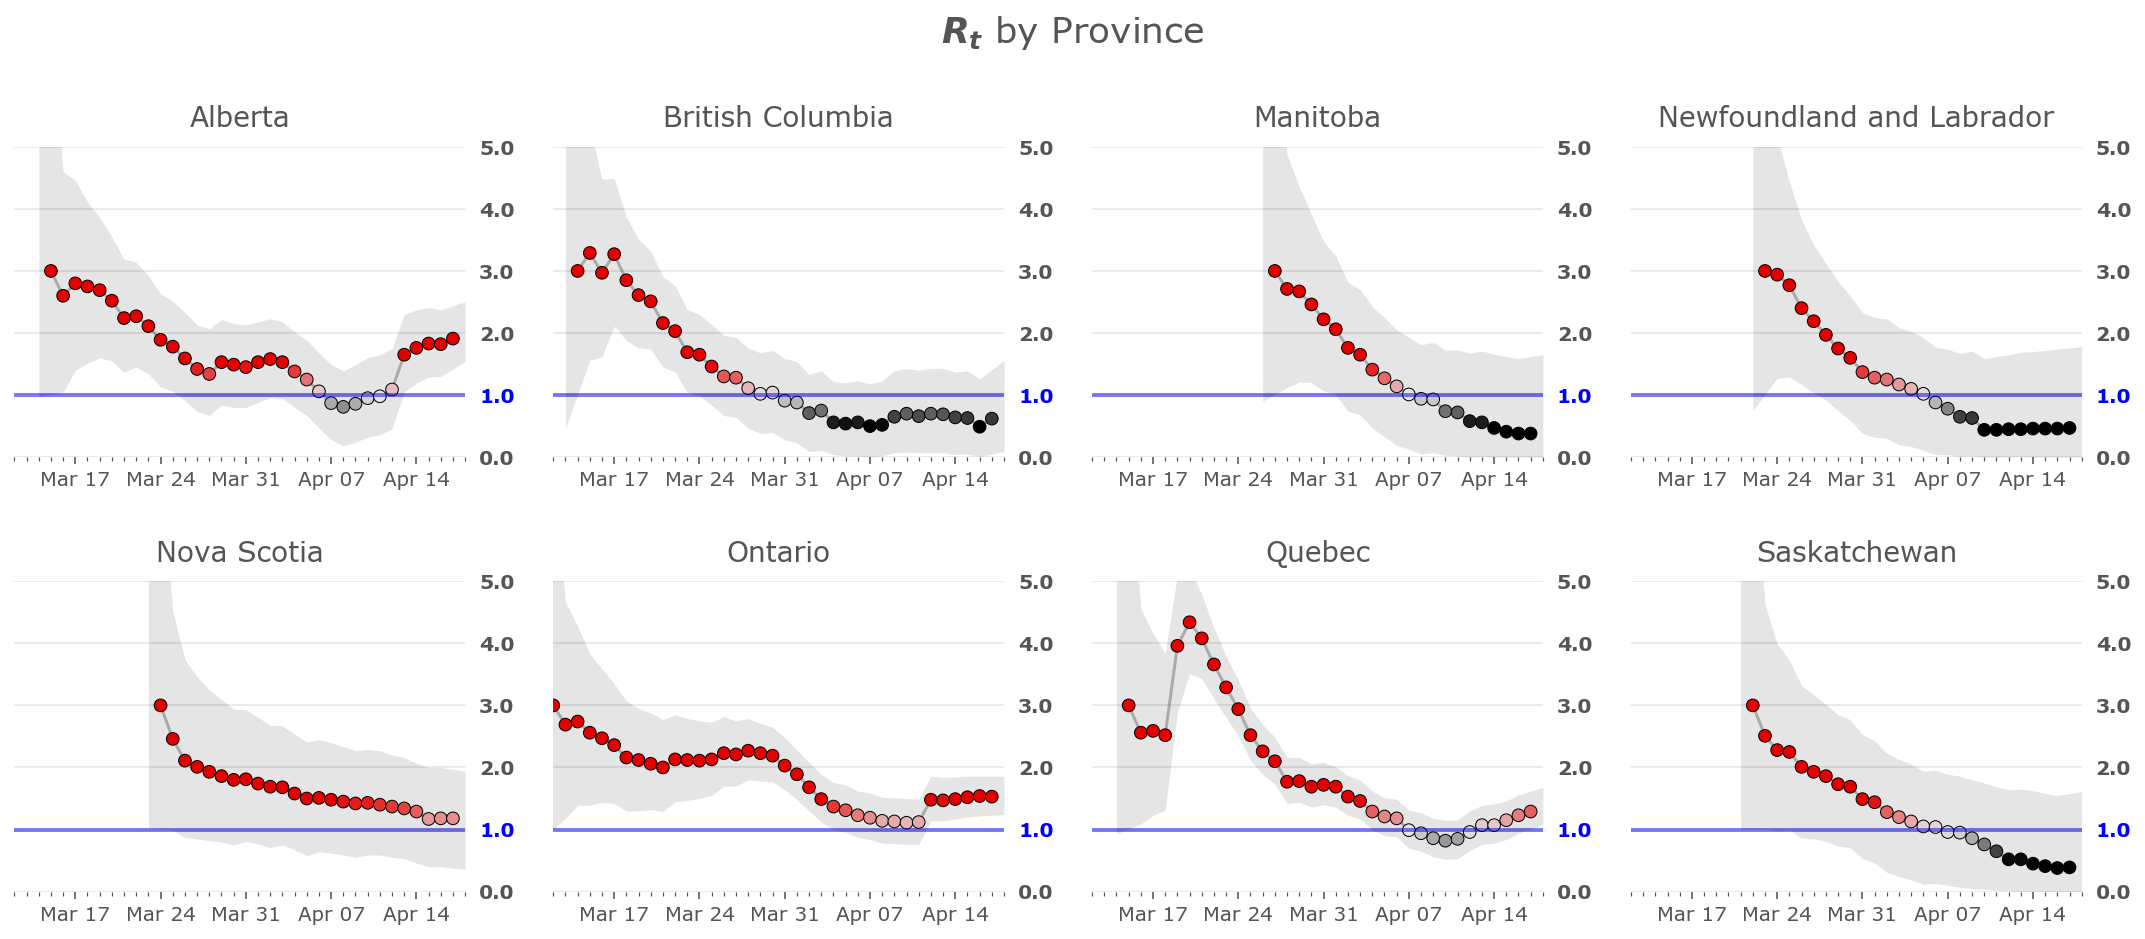

In [4]:
date_min = pd.to_datetime('2020-03-12')
ncols = 4
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(final_results.groupby('state')):
    plot_rt(result, axes.flat[i], state_name, date_min=date_min)
        
fig.tight_layout()
plt.subplots_adjust(hspace=0.4)
fig.suptitle('$R_t$ by Province', fontsize=18, y=1.08)
fig.set_facecolor('w')

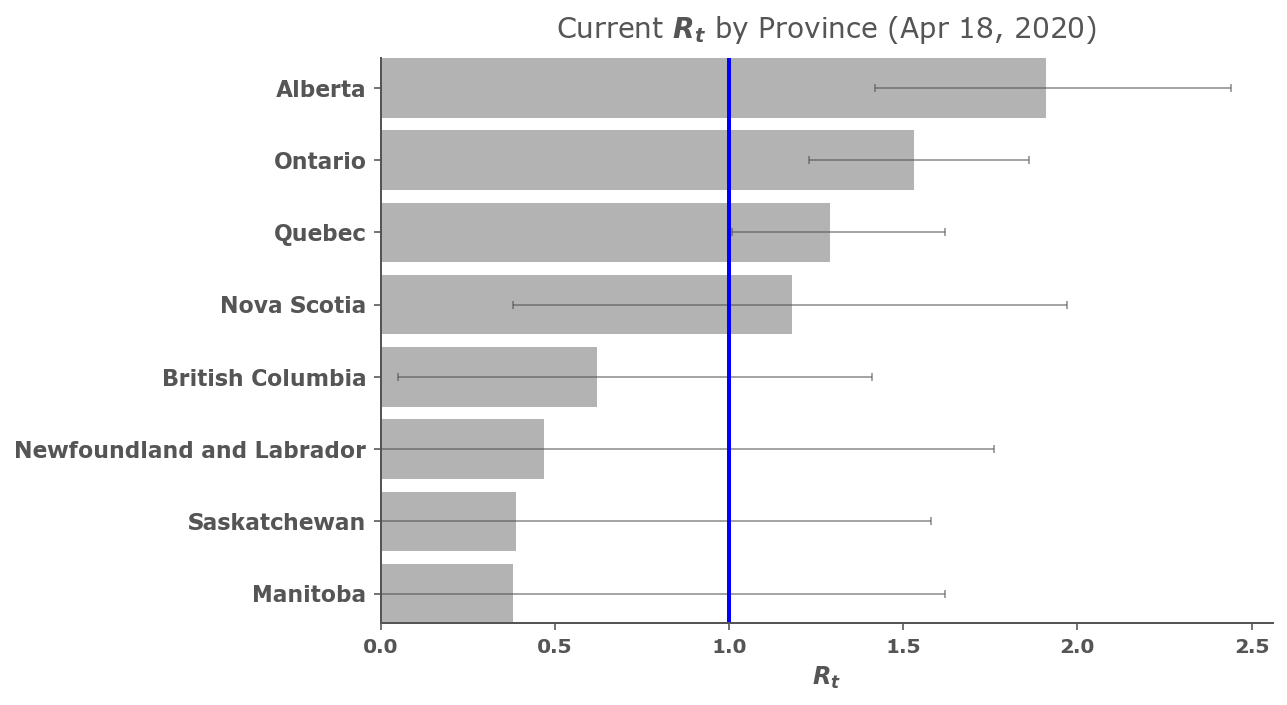

In [5]:
mr = final_results.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
today = datetime.today().strftime('%b %d, %Y')

def plot_standings(mr, figsize=(8, 5), title=f'Current $R_t$ by Province ({today})'):
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.barh(mr.index,
                   mr['ML'],
                   height=.825,
                   color='0.7',
                   ecolor='0.3',
                   capsize=2,
                   error_kw={'alpha':.5, 'lw':1},
                   xerr=err.values.T)

    labels = mr.index.to_series()
    ax.set_yticklabels(labels, fontsize=11)
    ax.margins(0)
    ax.set_xlim(0, 1.05 * mr['High_90'].max())
    ax.set_xlabel('$R_t$', fontsize=12)
    ax.axvline(1.0, color='b', lw=2)
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);